<a id=2></a>
# **Importing libraries**

In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

from pylab import *
from pyspark.sql.functions import udf, concat, col, lit
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
Spark_Con = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
sp = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(Spark_Con)

23/04/10 16:53:35 WARN Utils: Your hostname, cis6180 resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/04/10 16:53:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/10 16:53:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# creating spark dataframe

In [2]:
df = sp.read.format("csv").option("header", "true").load('../waterquality.csv')
gdf = gpd.read_file('Indian_States.shp')

In [3]:
df.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|  8|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

In [4]:
df.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'string'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

<a id=4></a>
# **Data Cleaning**

In [5]:
from pyspark.sql.types import FloatType

#### Converting the required columns in the float data type for calculation

In [6]:
df = df.withColumn("TEMP",df["TEMP"].cast(FloatType()))
df = df.withColumn("pH",df["pH"].cast(FloatType()))
df = df.withColumn("DO",df["DO"].cast(FloatType()))
df = df.withColumn("CONDUCTIVITY",df["CONDUCTIVITY"].cast(FloatType()))
df = df.withColumn("BOD",df["BOD"].cast(FloatType()))
df = df.withColumn("NITRATE_N_NITRITE_N",df["NITRATE_N_NITRITE_N"].cast(FloatType()))
df = df.withColumn("FECAL_COLIFORM",df["FECAL_COLIFORM"].cast(FloatType()))
df.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'string')]

#### Drop the TOTAL_COLIFORM column which is not required . 

In [7]:
df=df.drop('TOTAL_COLIFORM')

#### Remove all the rows with null value in it. To apply a SQL query, we need to first register it as a temporary table and then execute the query.

In [8]:
df.createOrReplaceTempView("df_sql")

In [9]:
df_clean = sp.sql('''Select * from df_sql where TEMP is not null and DO is not null 
                        and pH is not null and BOD is not null and CONDUCTIVITY is not null
                        and NITRATE_N_NITRITE_N is not null and FECAL_COLIFORM is not null''')

<a id=5></a>
# **EDA**

In [10]:
df_clean.createOrReplaceTempView("df_sql")

In [11]:
do = sp.sql("Select DO from df_sql")
do = do.rdd.map(lambda row : row.DO).collect()
ph = sp.sql("Select pH from df_sql")
ph = ph.rdd.map(lambda row : row.pH).collect()
bod = sp.sql("Select BOD from df_sql")
bod = bod.rdd.map(lambda row : row.BOD).collect()
nn = sp.sql("Select NITRATE_N_NITRITE_N from df_sql")
nn = nn.rdd.map(lambda row : row.NITRATE_N_NITRITE_N).collect()

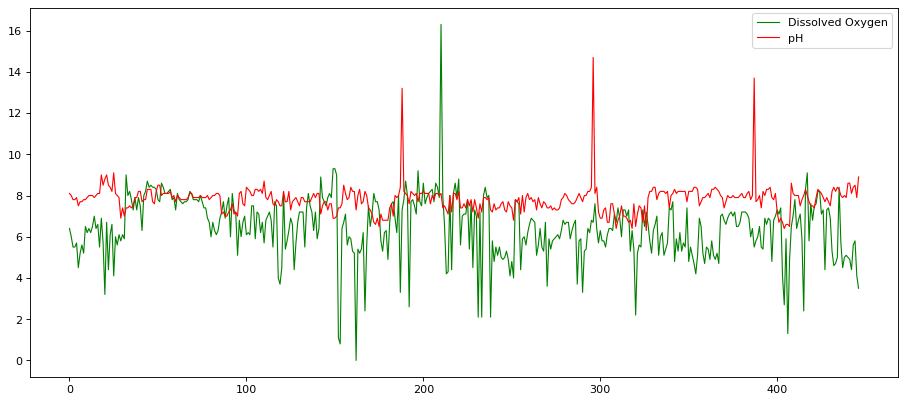

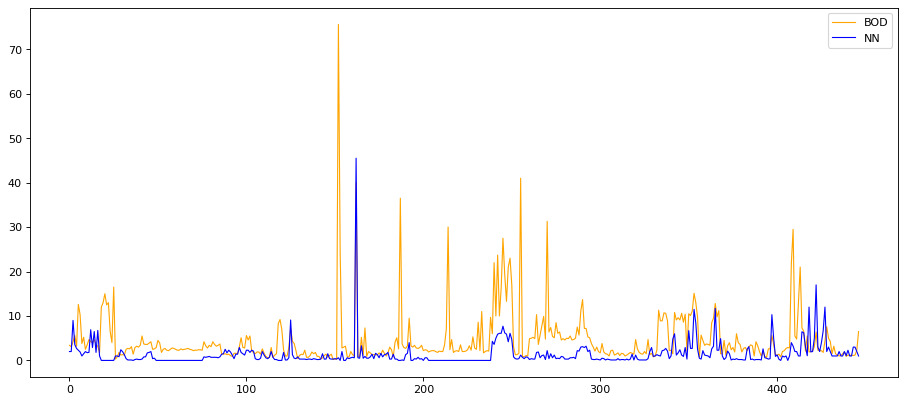

In [12]:
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
size=len(do)
ax.plot(range(0,size), do, color='green', animated=True, linewidth=1, label='Dissolved Oxygen')
ax.plot(range(0,size), ph, color='red', animated=True, linewidth=1, label='pH')
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), bod, color='orange', animated=True, linewidth=1, label='BOD')
ax2.plot(range(0,size), nn, color='blue', animated=True, linewidth=1, label='NN')
legend=ax.legend()
legend=ax2.legend()

In [13]:
con = sp.sql("Select CONDUCTIVITY from df_sql")
con = con.rdd.map(lambda row : row.CONDUCTIVITY).collect()
fec = sp.sql("Select FECAL_COLIFORM from df_sql")
fec = fec.rdd.map(lambda row : row.FECAL_COLIFORM).collect()

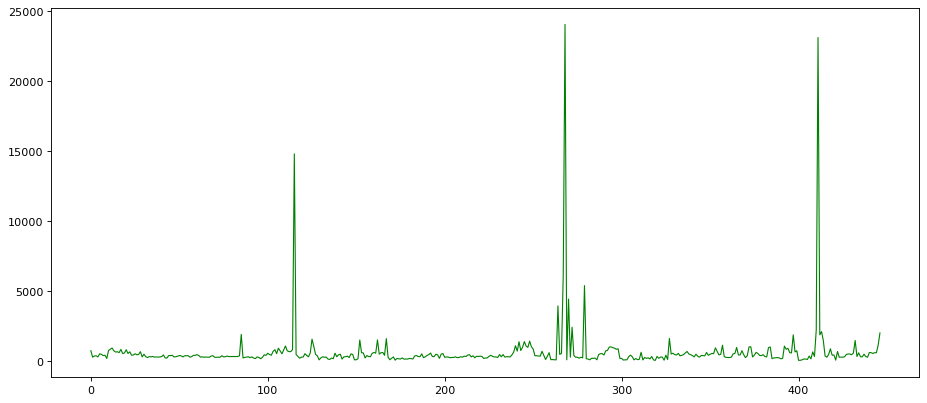

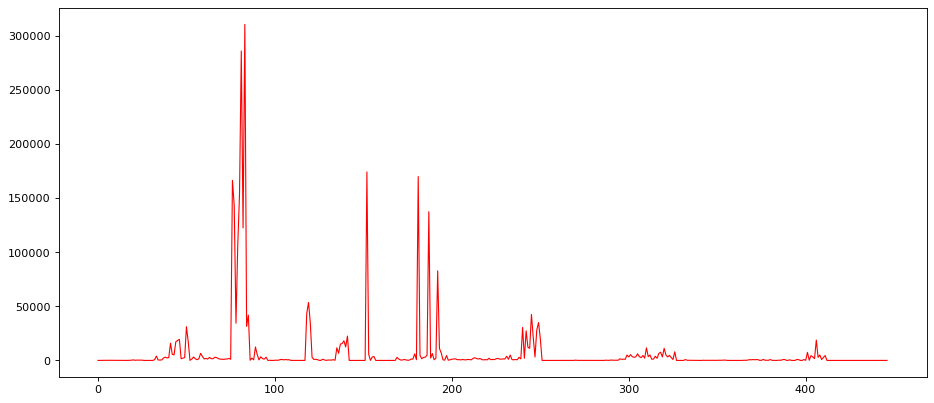

In [14]:
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,size), con, color='green', animated=True, linewidth=1)
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), fec, color='red', animated=True, linewidth=1)

<a id=6></a>
# **Feature Engineering**

#### Let us convert our data to pandas frame. We are doing this because to train a model we need what we have to predict which is not in data. So we have to calculate water quality index which requires many steps but can be easily done using pandas and in less number of steps. Also we will able to visualize our data in tabular form more effectively.

In [15]:
df=df_clean.toPandas()
df.dtypes

STATION CODE            object
LOCATIONS               object
STATE                   object
TEMP                   float32
DO                     float32
pH                     float32
CONDUCTIVITY           float32
BOD                    float32
NITRATE_N_NITRITE_N    float32
FECAL_COLIFORM         float32
dtype: object

### Initialization

In [16]:
start=0
end=448
station=df.iloc [start:end ,0]
location=df.iloc [start:end ,1]
state=df.iloc [start:end ,2]
do= df.iloc [start:end ,4].astype(np.float64)
value=0
ph = df.iloc[ start:end,5]  
co = df.iloc [start:end ,6].astype(np.float64)
bod = df.iloc [start:end ,7].astype(np.float64)
na= df.iloc [start:end ,8].astype(np.float64)
fc=df.iloc [2:end ,9].astype(np.float64)



In [17]:
df=pd.concat([station,location,state,do,ph,co,bod,na,fc],axis=1)
df. columns = ['station','location','state','do','ph','co','bod','na','fc']

### The Water Quality Index is calculated by aggregating the quality rating with the weight linearly, 
#### WQI = ∑ (qn x Wn)
#### where qn =Quality rating for the nth Water quality parameter, Wn= unit weight for the nth parameters.       
#### Although for calculation qn we have standard formula but it was not possible in this case, so we applied a standard method for calculating quality rating for each parameter.

In [18]:
df['npH']=df.ph.apply(lambda x: (100 if (8.5>=x>=7)  
                                 else(80 if  (8.6>=x>=8.5) or (6.9>=x>=6.8) 
                                      else(60 if (8.8>=x>=8.6) or (6.8>=x>=6.7) 
                                          else(40 if (9>=x>=8.8) or (6.7>=x>=6.5)
                                              else 0)))))

In [19]:
df['ndo']=df.do.apply(lambda x:(100 if (x>=6)  
                                 else(80 if  (6>=x>=5.1) 
                                      else(60 if (5>=x>=4.1)
                                          else(40 if (4>=x>=3) 
                                              else 0)))))

In [20]:
df['nco']=df.fc.apply(lambda x:(100 if (5>=x>=0)  
                                 else(80 if  (50>=x>=5) 
                                      else(60 if (500>=x>=50)
                                          else(40 if (10000>=x>=500) 
                                              else 0)))))

In [21]:
df['nbdo']=df.bod.apply(lambda x:(100 if (3>=x>=0)  
                                 else(80 if  (6>=x>=3) 
                                      else(60 if (80>=x>=6)
                                          else(40 if (125>=x>=80) 
                                              else 0)))))

In [22]:
df['nec']=df.co.apply(lambda x:(100 if (75>=x>=0)  
                                 else(80 if  (150>=x>=75) 
                                      else(60 if (225>=x>=150)
                                          else(40 if (300>=x>=225) 
                                              else 0)))))

In [23]:
df['nna']=df.na.apply(lambda x:(100 if (20>=x>=0)  
                                 else(80 if  (50>=x>=20) 
                                      else(60 if (100>=x>=50)
                                          else(40 if (200>=x>=100) 
                                              else 0)))))

df.head()
df.dtypes

station      object
location     object
state        object
do          float64
ph          float32
co          float64
bod         float64
na          float64
fc          float64
npH           int64
ndo           int64
nco           int64
nbdo          int64
nec           int64
nna           int64
dtype: object

#### Now we apply the formula of wqi by first multiplying all the quality rating with its weight and then summed all the values.

In [24]:
df['wph']=df.npH * 0.165
df['wdo']=df.ndo * 0.281
df['wbdo']=df.nbdo * 0.234
df['wec']=df.nec* 0.009
df['wna']=df.nna * 0.028
df['wco']=df.nco * 0.281
df['wqi']=df.wph+df.wdo+df.wbdo+df.wec+df.wna+df.wco 
df

,station,location,state,do,ph,co,bod,na,fc,npH,...,nbdo,nec,nna,wph,wdo,wbdo,wec,wna,wco,wqi
0,1312,"GODAVARI AT JAYAKWADI DAM, AURNAGABAD,MAHARASHTRA",MAHARASHTRA,6.4,8.1,735.0,3.4,2.00,NaN,100,...,80,0,100,16.5,28.10,18.72,0.00,2.8,0.00,66.12
1,2177,GODAVARI RIVER NEAR SOMESHWAR TEMPLE.,MAHARASHTRA,6.0,8.0,270.0,3.1,2.00,NaN,100,...,80,40,100,16.5,28.10,18.72,0.36,2.8,0.00,66.48
2,2182,GODAVARI RIVER AT SAIKHEDA.,MAHARASHTRA,5.5,7.8,355.0,4.2,9.00,59.0,100,...,80,0,100,16.5,22.48,18.72,0.00,2.8,16.86,77.36
3,2179,"GODAVARI RIVER AT HANUMAN GHAT, NASHIK CITY.",MAHARASHTRA,5.5,7.8,371.0,5.6,3.55,90.0,100,...,80,0,100,16.5,22.48,18.72,0.00,2.8,16.86,77.36
4,2183,GODAVARI RIVER AT NANDUR- MADMESHWAR DAM.,MAHARASHTRA,5.7,7.9,294.0,3.2,2.69,45.0,100,...,80,40,100,16.5,22.48,18.72,0.36,2.8,22.48,83.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,2940,"GAPE- SAGAR LAKE, DUNGARPUR, RAJASTHAN",RAJASTHAN,4.4,8.1,538.0,1.2,1.00,5.0,100,...,100,0,100,16.5,16.86,23.40,0.00,2.8,28.10,87.66
443,2941,"LAKE JAISAMAND, SALUMBER, UDAIPUR, POINT NO. 1...",RAJASTHAN,5.6,8.4,591.0,1.1,3.00,4.0,100,...,100,0,100,16.5,22.48,23.40,0.00,2.8,28.10,93.28
444,2942,"LAKE JAISAMAND, SALUMBER, UDAIPUR, POINT NO. 2...",RAJASTHAN,5.8,8.5,588.0,1.2,3.00,4.0,100,...,100,0,100,16.5,22.48,23.40,0.00,2.8,28.10,93.28
445,2943,"LODHA TALAB, BANSWARA- DUNGARPUR ROAD, BANSWAR...",RAJASTHAN,4.1,7.9,1133.0,2.3,2.00,7.0,100,...,100,0,100,16.5,0.00,23.40,0.00,2.8,22.48,65.18


#### Then we classify the water on the basis of their water quality index.

In [25]:
df['quality']=df.wqi.apply(lambda x:('Excellent' if (25>=x>=0)  
                                 else('Good' if  (50>=x>=26) 
                                      else('Poor' if (75>=x>=51)
                                          else('Very Poor' if (100>=x>=76) 
                                              else 'Unsuitable')))))

#### Let's visualize the water quality index in each state of India.

In [26]:
#renaming state names
gdf['st_nm'].replace({"Andaman & Nicobar Island": "Andaman and Nicobar Islands",
                      "Arunanchal Pradesh": "Arunachal Pradesh",
                      'Dadara & Nagar Havelli':'Dadra and Nagar Haveli and Daman and Diu',
                      'Jammu & Kashmir':'Jammu and Kashmir',
                      'NCT of Delhi':'Delhi'}, inplace=True)
df['state'].replace({"TAMILNADU": "TAMIL NADU"}, inplace=True)

#Capitalizing only the first letter of each word
df['state'] = df['state'].str.title()

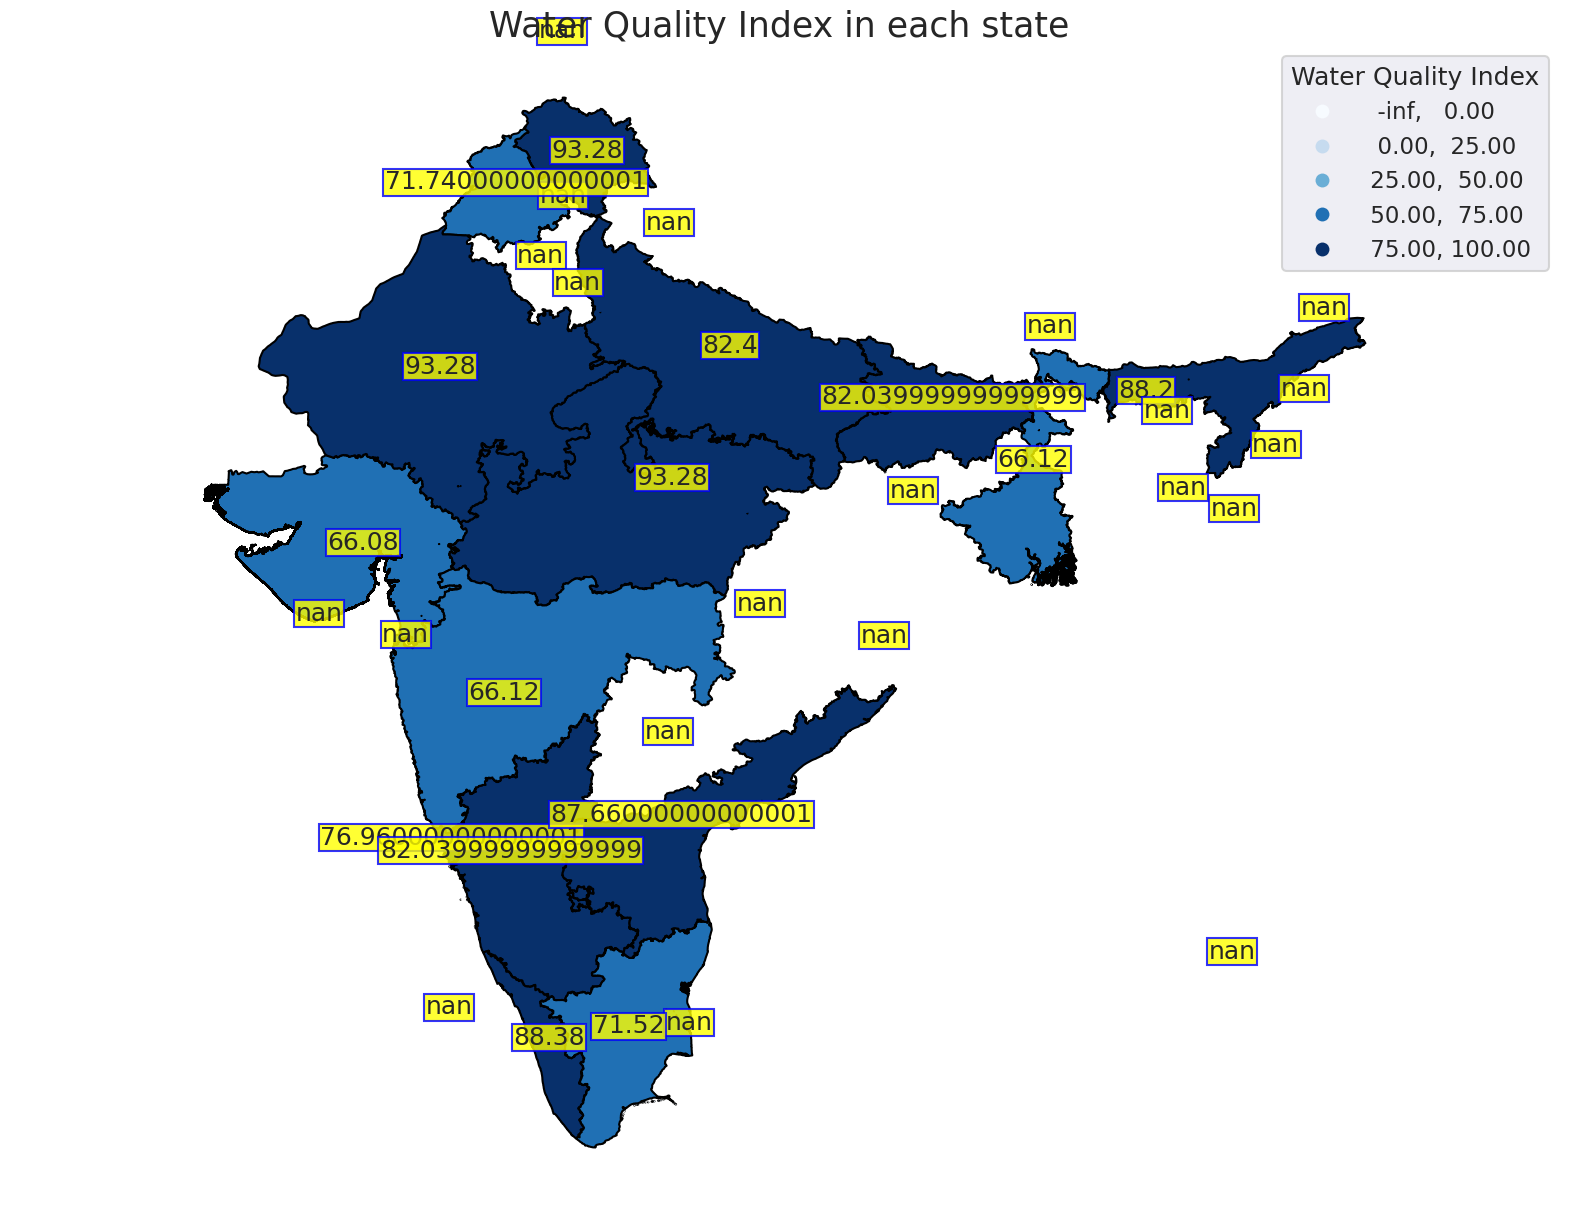

In [27]:
gdf = gdf.rename(columns={"st_nm": "state"})
merged = pd.merge(gdf, df , how='outer', on='state')
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
merged = merged.drop_duplicates(subset ="state") 

sns.set_context("talk")
sns.set_style("dark")
cmap = 'Blues'
figsize = (20, 15)
ax = merged.plot(column= 'wqi', cmap=cmap, 
                          figsize=figsize, scheme='User_Defined',
                          classification_kwds=dict(bins=[0,25,50,75,100]),
                          edgecolor='black', legend = True)
for idx, row in merged.iterrows():
    ax.text(row.coords[0], row.coords[1], s=row['wqi'], horizontalalignment='center', bbox={'facecolor': 'yellow', 'alpha':0.8, 'pad': 1, 'edgecolor':'blue'})

ax.get_legend().set_title('Water Quality Index')
ax.set_title("Water Quality Index in each state ", size = 25)

ax.set_axis_off()
plt.axis('equal')
plt.show()

#### Let us again convert the whole data in spark frame for further processes.

In [28]:
spark_df = sqlContext.createDataFrame(df)

In [29]:
spark_df.show()

+-------+--------------------+--------------+-----------------+-----------------+-----+------------------+------------------+-----+---+---+---+----+---+---+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|station|            location|         state|               do|               ph|   co|               bod|                na|   fc|npH|ndo|nco|nbdo|nec|nna|               wph|               wdo|              wbdo|               wec|               wna|               wco|              wqi|  quality|
+-------+--------------------+--------------+-----------------+-----------------+-----+------------------+------------------+-----+---+---+---+----+---+---+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|   1312|GODAVARI AT JAYAK...|   Maharashtra|6.400000095367432|8.100000381469727|735.0|3.40000009536743

In [30]:
spark_df.createOrReplaceTempView("df_sql")

In [31]:
State = sp.sql("Select state from df_sql")
State = State.rdd.map(lambda row : row.state).collect()

In [32]:
Wqi = sp.sql("Select wqi from df_sql")
Wqi = Wqi.rdd.map(lambda row : row.wqi).collect()

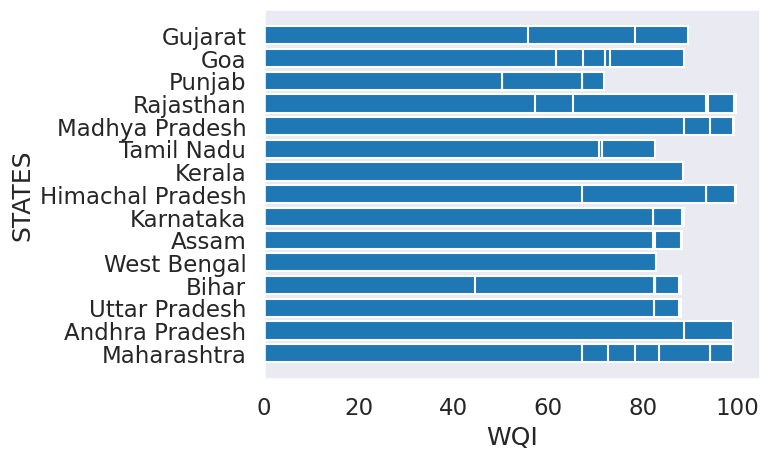

In [33]:
plt.barh(State,Wqi)

plt.xlabel("WQI")
plt.ylabel("STATES")


plt.show()

<a id=7></a>
# **Model Creation**
#### Now we apply machine learning and deep learning algorithms to predict the data.



#### In this, first data is converted which are required to predict WQI into vector form by using VectorAssembler. Then we normalize our data by using Normalizer.

In [34]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression



#### Before training, our data is randomly split in two parts so as to avoid overfitting and then training is done.

In [35]:
train_data,test_data=spark_df.randomSplit([0.8,0.2])

In [36]:
vectorAssembler = VectorAssembler(inputCols=["npH","ndo","nbdo","nec","nna","nco"], outputCol="features")
normalizer = Normalizer(inputCol="features",outputCol="features_norm")

## Linear Regresion Model
#### Then import LinearRegression from pyspark.ml.regression and applied it to our normalized data. Afterthat, import Pipeline from pyspark.ml and include all those steps in the pipeline that have been done.

In [37]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

In [38]:
LR = LinearRegression(featuresCol="features_norm",labelCol="wqi")

# Evaluate model
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="wqi", metricName="r2")

# Create ParamGrid for Cross Validation
LRparamGrid = (ParamGridBuilder()
             .addGrid(LR.regParam, [ 1.0, 2.0])
             #  .addGrid(lr.regParam, [0.01, 0.1, 0.5])
             .addGrid(LR.elasticNetParam, [0.25, 0.5, 0.75, 1.0])
             #  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(LR.maxIter, [1, 5, 10, 20, 50])
             #  .addGrid(lr.maxIter, [1, 5, 10])
             .build())

# Create 5-fold CrossValidator
LRcv = CrossValidator(estimator = LR,
                      estimatorParamMaps = LRparamGrid,
                      evaluator = evaluator,
                      numFolds = 5)


In [39]:
pipeline = Pipeline(stages=[vectorAssembler,normalizer,LRcv])

In [40]:
LRmodel = pipeline.fit(train_data)

23/04/10 16:53:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/04/10 16:53:55 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/10 16:53:55 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [41]:
LRpredictions = LRmodel.transform(train_data)

In [42]:
LRpredictions.select("wqi","prediction").show()

+-----------------+-----------------+
|              wqi|       prediction|
+-----------------+-----------------+
|82.03999999999999|81.52753990858236|
|             82.4|81.46503038846049|
|             82.4|81.46503038846049|
|            66.12|68.60394994061787|
|            66.12|68.60394994061787|
|            66.12|68.60394994061787|
|            66.12|68.60394994061787|
|             82.4|81.46503038846049|
|            77.72|77.90792092715353|
|            66.12|68.60394994061787|
|82.03999999999999|81.52753990858236|
|            66.12|68.60394994061787|
|82.03999999999999|81.52753990858236|
|82.03999999999999|81.52753990858236|
|82.03999999999999|81.52753990858236|
|93.82000000000001|90.90021733436146|
|            77.36|77.78859710894648|
|            82.98|82.89929386726797|
|             82.4|81.46503038846049|
|             77.9|78.52093899768477|
+-----------------+-----------------+
only showing top 20 rows



#### Now we check the performance of our model.

In [43]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
LRevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="wqi", metricName="mse")
print('MSE:', LRevaluator.evaluate(LRpredictions))
LRevaluator.setMetricName('r2')
print('R2:', LRevaluator.evaluate(LRpredictions))

MSE: 5.650138855803565
R2: 0.9682287944288213


# Random Forest

In [44]:
from pyspark.ml.regression import RandomForestRegressor

In [45]:
RF = RandomForestRegressor(featuresCol="features_norm",labelCol="wqi")

# Evaluate model
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="wqi", metricName="r2")

# Create ParamGrid for Cross Validation
RFparamGrid = (ParamGridBuilder()
#              .addGrid(RF.maxDepth, [2, 5, 10, 20, 30])
               .addGrid(RF.maxDepth, [2, 5, 10])
#              .addGrid(RF.maxBins, [10, 20, 40, 80, 100])
               .addGrid(RF.maxBins, [5, 10, 20])
#              .addGrid(RF.numTrees, [5, 20, 50, 100, 500])
               .addGrid(RF.numTrees, [5, 20, 50])
             .build())

# Create 5-fold CrossValidator
RFcv = CrossValidator(estimator = RF,
                      estimatorParamMaps = RFparamGrid,
                      evaluator = evaluator,
                      numFolds = 5)



In [46]:
pipeline = Pipeline(stages=[vectorAssembler,normalizer,RFcv])

In [47]:
RFcvmodel = pipeline.fit(train_data)

In [48]:
# Use test set here so we can measure the accuracy of our model on new data
RFpredictions = RFcvmodel.transform(test_data)

In [49]:
RFpredictions.select("prediction",'wqi').show()

+-----------------+-----------------+
|       prediction|              wqi|
+-----------------+-----------------+
|66.53170760869564|            66.12|
|82.37713279087443|             82.4|
|77.39775000000002|77.36000000000001|
|66.53170760869564|            66.12|
|66.53170760869564|            66.12|
|82.03801374422677|82.03999999999999|
|66.53170760869564|            66.12|
|82.37713279087443|             82.4|
|82.37713279087443|             82.4|
|72.23830000000001|            66.48|
|82.78736547619049|            82.98|
|67.04101923076922|            67.06|
|75.82183333333333|71.52000000000001|
|66.53170760869564|            66.12|
|82.37713279087443|             82.4|
|82.03801374422677|82.03999999999999|
|83.31482961724267|            83.34|
|77.39775000000002|77.36000000000001|
|          76.1475|            76.78|
| 71.2756333333333|             70.8|
+-----------------+-----------------+
only showing top 20 rows



### cvModel uses the best model found from the Cross Validation
# Evaluate the model

In [50]:
RFevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="wqi", metricName="mse")

In [52]:
print('MSE:', RFevaluator.evaluate(RFpredictions))
RFevaluator.setMetricName('r2')
print('R2:', RFevaluator.evaluate(RFpredictions))

MSE: 4.762255325585854
R2: 0.9743101192852988


# Decision Tree

In [53]:
from pyspark.ml.regression import DecisionTreeRegressor

In [57]:
DT = DecisionTreeRegressor(featuresCol="features_norm",labelCol="wqi")

# Evaluate model
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="wqi", metricName="r2")

# Create ParamGrid for Cross Validation
DTparamGrid = (ParamGridBuilder()
               .addGrid(DT.maxDepth, [2, 5, 10])
               .addGrid(DT.maxBins, [5, 10, 20])
             .build())

DTcv = CrossValidator(estimator = DT,
                      estimatorParamMaps = DTparamGrid,
                      evaluator = evaluator,
                      numFolds = 5)


In [59]:
pipeline = Pipeline(stages=[vectorAssembler,normalizer,DTcv])

In [60]:
DTcvmodel = pipeline.fit(train_data)

In [61]:
# Use test set here so we can measure the accuracy of our model on new data
DTpredictions = DTcvmodel.transform(test_data)

In [62]:
DTpredictions.select("prediction",'wqi').show()

+-----------------+-----------------+
|       prediction|              wqi|
+-----------------+-----------------+
|            66.12|            66.12|
|             82.4|             82.4|
|77.42545454545456|77.36000000000001|
|            66.12|            66.12|
|            66.12|            66.12|
|81.99441860465113|82.03999999999999|
|            66.12|            66.12|
|             82.4|             82.4|
|             82.4|             82.4|
|             70.8|            66.48|
|83.19647058823529|            82.98|
|            67.06|            67.06|
|72.10000000000002|71.52000000000001|
|            66.12|            66.12|
|             82.4|             82.4|
|81.99441860465113|82.03999999999999|
|83.19647058823529|            83.34|
|77.42545454545456|77.36000000000001|
|             76.6|            76.78|
|             70.8|             70.8|
+-----------------+-----------------+
only showing top 20 rows



## cvModel uses the best model found from the Cross Validation
# Evaluate best model

In [63]:
DTevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="wqi", metricName="mse")

In [64]:

print('MSE:', DTevaluator.evaluate(DTpredictions))
DTevaluator.setMetricName('r2')
print('R2:', DTevaluator.evaluate(DTpredictions))

MSE: 4.961815206700765
R2: 0.97323359793338


# GBT

In [65]:
from pyspark.ml.regression import GBTRegressor

In [66]:
# Train a Gradient-boosted Tree Regressor using cross-validation
gbt = GBTRegressor(labelCol="wqi", featuresCol="features_norm", seed=123)
paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth, [5, 10, 15]).build()
GBTcv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5, seed=123)
pipeline = Pipeline(stages=[vectorAssembler,normalizer,GBTcv])
cvModelGBT = pipeline.fit(train_data)
predictionsGBT = cvModelGBT.transform(test_data)

In [67]:
predictionsGBT.select("prediction",'wqi').show()

+-----------------+-----------------+
|       prediction|              wqi|
+-----------------+-----------------+
|66.11329359846238|            66.12|
|82.37975416907685|             82.4|
|77.41476069715914|77.36000000000001|
|66.11329359846238|            66.12|
|66.11329359846238|            66.12|
|81.88631614760716|82.03999999999999|
|66.11329359846238|            66.12|
|82.37975416907685|             82.4|
|82.37975416907685|             82.4|
|67.47578702050991|            66.48|
|    82.8010570797|            82.98|
|67.59780451827714|            67.06|
|77.00554197215195|71.52000000000001|
|66.11329359846238|            66.12|
|82.37975416907685|             82.4|
|81.88631614760716|82.03999999999999|
|82.51075507602782|            83.34|
|77.41476069715914|77.36000000000001|
|77.50516034519978|            76.78|
|70.97298335964958|             70.8|
+-----------------+-----------------+
only showing top 20 rows



In [68]:
GBTevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="wqi", metricName="mse")
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('MSE:', GBTevaluator.evaluate(predictionsGBT))
GBTevaluator.setMetricName('r2')
print('R2:', GBTevaluator.evaluate(predictionsGBT))

MSE: 4.5552142847148875
R2: 0.97542699758757
